# M4 | Predicting Users' Performance Based On Their Activity Behaviour

## Task 0: Research Question
*Our goal was to predict users performance based on their activity behaviour. To this end, we extracted different features as a proxy for their studying habits.*


## Task 1: Data Preprocessing


### Imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import Image

DATA_DIR = './data'

### Data Cleaning

**Important**: Since our preprocessing is quite extensive, we decided to *not* include it here in the notebook. Instead, we already provide you with the preprocessed data. 
This section will give you an overview of the employed preprocessing steps via statistics and visualisations. Feel free to inspect the preprocessing code by tracing it starting from `src/data_cleaning.py`.

#### Removal of non-mappable courses

After discussing with Tom from Gogymi, we removed all data points with the course id 1696, 8117, 2019, 8117, 0, 2515, 2440. These courses were either used in the development of the platform or were the platform introduction course for students and teachers, respectively. This removed 7.1% of the data from `activity.csv`.


#### Removal of non-first attempts

We removed **1596 entries (24.81%)** from `all_scores` to retain only the **first exam attempt per user**. This step is important because repeated attempts can distort the measurement of true performance: students who retake an exam are likely to recall specific questions from earlier attempts, which gives them an advantage that doesn't necessarily reflects their initial understanding. We therefore keep only the **chronologically first attempt** for each `(user_id, test_id)` pair.

#### Assigning domains to the activity and results data

The dataset included overview files for both activities and exam results. However, these files contained mixed data from the platform’s three domains: **math**, **text**, and **essay**.  
We found it important to separate the data points by their respective domains to build a meaningful model.

To achieve this, we created a mapping between test IDs and domains, based on the IDs found in `math_results.csv`, `essay_results.csv`, and `text_results.csv`. We then applied this mapping to both `activity.csv` and `all_scores.csv`.

Initially, there were some overlaps between IDs assigned to the math and the essay domain. After discussing this issue with Tom, we received an updated version of `math_results.csv` (included in this project), which corrected these assignments. Specifically, the IDs **3301** and **5447** were originally assigned to both essay and math, but they should only belong to the essay domain.  
**With this correction, we were able to successfully assign each ID to exactly one domain. As a result, all entries in both `all_scores.csv` and `activity.csv` could be mapped unambiguously.**

The final domain distributions are:

`activity.csv`
- Math courses: **48.0%** of data
- Text courses: **26.0%** of data
- Essay courses: **26.0%** of data

`all_scores.csv`
- Math courses: **79.0%** of data
- Text courses: **9.0%** of data
- Essay courses: **12.0%** of data

#### Handling incorrect and missing dates

`activity.csv`

While inspecting the timestamps in `activity.csv`, we identified some incorrect entries.  
A few activities had `activity_completed` dates from 1970, and in some cases, the recorded order of events was nonsensical — for example, activities appeared to finish before they started.

To address these inconsistencies, we focused on rows where:
- `activity_updated` < `activity_started`
- or `activity_completed` < `activity_started`

The findings:
- **57** rows had `activity_updated` before `activity_started`
- **1908** rows had `activity_completed` before `activity_started`
- In total, about **2.82%** of the dataset contained invalid timestamps.

We attempted to restore timestamps using `activity_updated` wherever possible.  
- For **1851** rows, `activity_updated` was equal to or after `activity_started`, allowing us to infer a valid completion time.
- However, for the remaining **57** rows, both `activity_updated` and `activity_completed` were before `activity_started`, making correction impossible.

Given that these unresolved cases represent only **0.08%** of the data, we marked them as invalid and excluded them from any time-based analyses.

`all_scores.csv`

Since `all_scores.csv` only contains one time-related column (`date`) there could no be inconsistencies in date ordering. All dates lied within in a reasonable time range, which is why we did not perform any additional cleaning on them.

#### Time Coverage and Timestamp Consistency

After cleaning inconsistent and unrealistic dates, we compared the timestamp ranges between `activity.csv` and `all_scores.csv`:

|                | `activity_dates`         | `scores_dates`          |
|----------------|---------------------------|--------------------------|
| **Minimum**    | 2023-04-07 16:42:35        | 2023-04-07 17:26:54       |
| **Maximum**    | 2025-03-07 14:55:42        | 2025-03-05 18:17:37       |
| **Count**      | 173,097                    | 4,836                    |


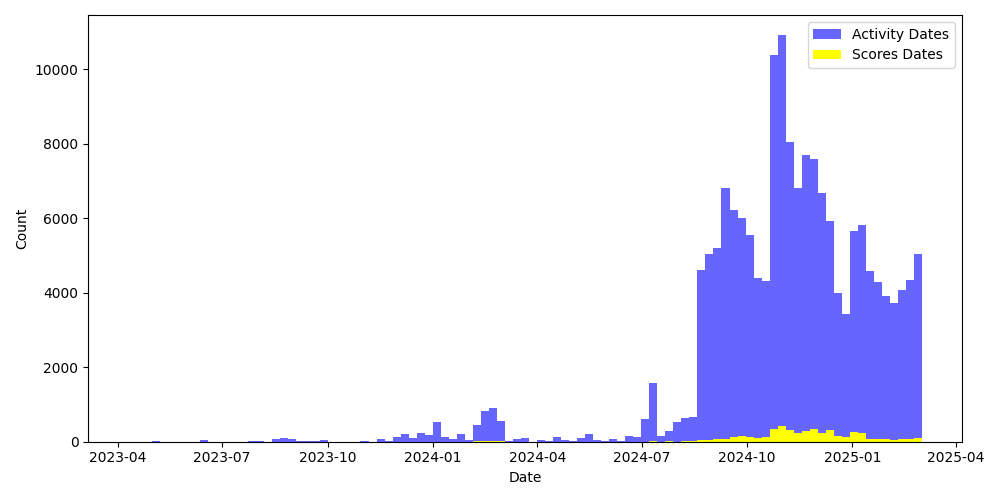

In [49]:
Image(filename='plots/data_cleaning/Weekly Distribution of Activity and Score Dates.png')

Key observations:
- There are approximately **35.79 times** more timestamps in `activity.csv` than in `all_scores.csv`
- The dataset covers a total time span of **699 days**
- Both dataframes cover almost the exact same timeframe, with `activity.csv` covering two more dates
- The timestamps fall within a consistent and reasonable range (between 2023-04-07 and 2025-03-07)
- The distribution of dates shows that most of the available data was recorded in the timeframe between July 2024 and March 2025


#### Removal of activities with a duration of 0 seconds

In [50]:
activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

Time spent on activities is one of the key behavioral features we use to analyze student behavior. Unfortunately, many activity entries have a recorded duration of zero, making them unusable for time-based analysis. The following graph shows how many data points are affected by this issue.

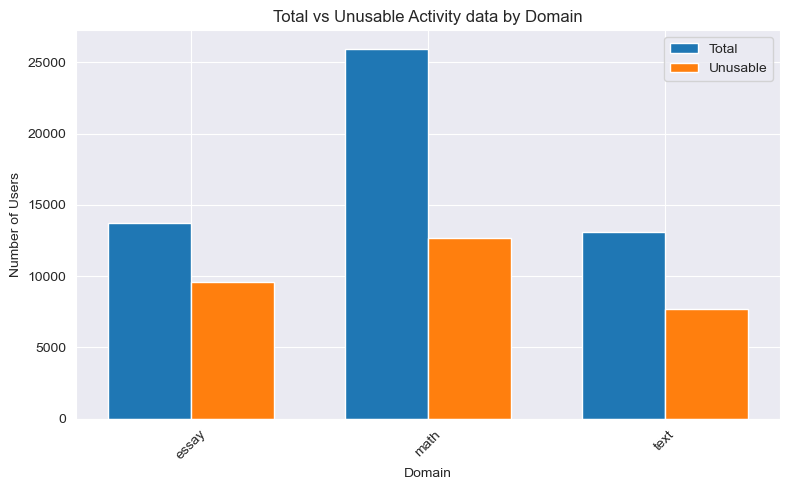

In [4]:
total = activity.groupby('domain')['user_id'].count()
unuseable = activity[activity['activity_completed'].isna()]
unuseable_count = unuseable.groupby('domain')['user_id'].count()

domains = sorted(set(total.index).union(set(unuseable_count.index)))
total = total.reindex(domains, fill_value=0)
unuseable_count = unuseable_count.reindex(domains, fill_value=0)

x = np.arange(len(domains))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, total, width, label='Total')
plt.bar(x + width/2, unuseable_count, width, label='Unusable')

plt.ylabel('Number of Users')
plt.xlabel('Domain')
plt.title('Total vs Unusable Activity data by Domain')
plt.xticks(x, domains, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
print(f'By deleting these colums, we lose {(unuseable_count.sum()/total.sum() * 100).round(2)} % of the initial data ...')

By deleting these colums, we lose 56.67 % of the initial data ...


In [6]:
activity.dropna(inplace=True)

**Comment:** 

This is quite a big loss of data but a necessary one... (see annexe for trial without this loss of data)

### Feature Engineering

Our aim is to predict a user's score on their first attempt at a specific exam, based on their behavior leading up to it. To train our model, we engineered the following features to capture and characterize user behavior:

| **Feature Name**                         | **Description**                                                                                                                                      |
|------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| `recent_avg_time_per_activity`           | Average time (in minutes) spent per activity during the last 10 days before the exam, including the exam day. Reflects recent engagement intensity. |
| `days_since_last_activity`               | Number of days between the user's most recent activity and the exam. A higher value indicates a longer gap in studying before the exam.             |
| `total_time_spent_on_activity_before_exam` | Total time (in minutes) the user spent on activities prior to the exam. Gives a sense of overall study investment.                                 |
| `average_performance_past_exams`         | Mean performance from the user's previous exams (before this one). Provides an estimate of historical performance.                                  |
| `avg_activities_per_day_recent`          | Average number of activities completed per day in the last 10-day window. Suggests consistency or intensity of preparation.                         |
| `active_days_ratio_recent`               | Proportion of days (out of the last 10) on which the user was active. Indicates study regularity.                                                   |
| `diversity_recent`                       | Number of unique activity types completed in the rolling window. Higher diversity may reflect varied engagement with learning content.             |

In [7]:
# Rolling window for recent activity
rolling_window_days = 10


def compute_all_features_for_exam(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']


    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()


    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}


    # Recent average time per activity (rolling window)
    total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0


    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan


    # Total time spent on activities before the exam
    features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0


    # Average performance on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan


    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan


    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)


**All features are calculated separately within each domain — Math, Text, and Essay — to capture domain-specific learning patterns and engagement.**

We have also scaled the features using a standard because we assume a normal distribution:

In [8]:
scaler = StandardScaler()
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','diversity_recent']

#### Math data 

In [9]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')

# scaling the columns
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df_math = pd.concat([scaled_df, remaining_df], axis=1)

In [10]:
final_df_math.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                     56
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              469
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [11]:
print('Total Nb of rows :', final_df_math.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', round(final_df_math.isna().any(axis=1).sum()/ final_df_math.user_id.count() * 100, 2))

Total Nb of rows : 3810
Nb of rows where we are missing feature values : 470
Percentage of rows where we are missing feature values : 12.34


**Comment:** Some features for certain rows cannot be computed, particularly the "average_performance_past_exams" feature. This occurs for the first exam questions attempted by each user, where no prior performance data is available.

**Comment:** For the math dataset, approximately 12% of the data is affected by this issue. However, if we were to remove this data the loss is minor and there are still around 3400 healthy data points that remain.

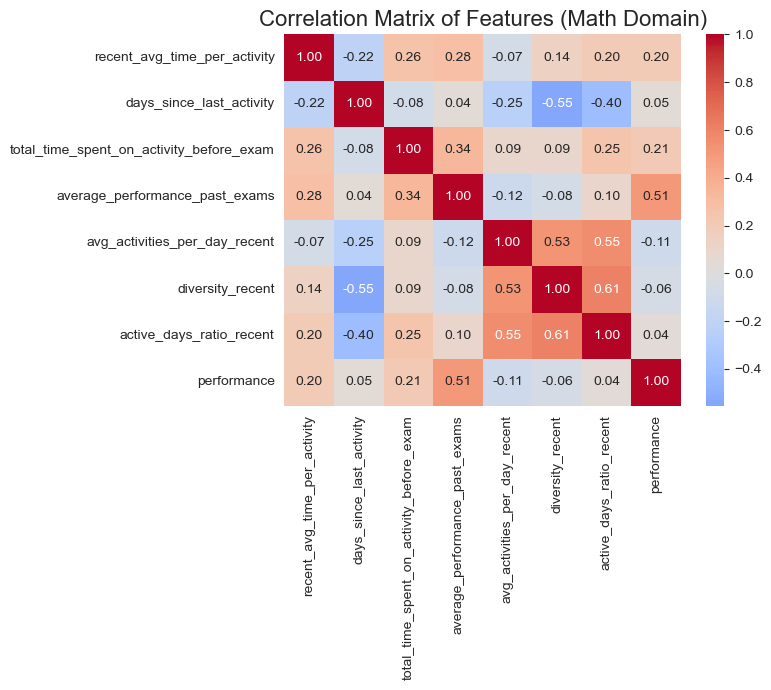

In [12]:
feature_columns = [
    'recent_avg_time_per_activity',
    'days_since_last_activity',
    'total_time_spent_on_activity_before_exam',
    'average_performance_past_exams',
    'avg_activities_per_day_recent',
    'diversity_recent',
    'active_days_ratio_recent',
    'performance'  
]

correlation_matrix_math = final_df_math[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_math, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Math Domain)", fontsize=16)
plt.tight_layout()
plt.show()

#### Essay data

In [13]:
performances_essay = performances[performances['domain']== 'essay'].copy()
activity_essay= activity[activity['domain']== 'essay'].copy()

# Convert the date columns  to datetime
activity_essay['activity_updated'] = pd.to_datetime(activity_essay['activity_updated'])
performances_essay['time'] = pd.to_datetime(performances_essay['time'])

# Loop over each exam (grouped by user) in performances_essay and compute all features.
features_list = []

for user_id, user_exams in performances_essay.groupby('user_id'):
    # Get corresponding activities for the user from activity_essay and sort by date
    user_activities = activity_essay[activity_essay['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_essay_features = performances_essay.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_essay_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_essay_features.index)
remaining_df = performances_essay_features.drop(columns=columns_to_scale)
final_df_essay = pd.concat([scaled_df, remaining_df], axis=1)

In [14]:
final_df_essay.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    193
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              308
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [15]:
print('Total Nb of rows :', final_df_essay.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', round(final_df_essay.isna().any(axis=1).sum()/ final_df_essay.user_id.count() * 100, 2))

Total Nb of rows : 581
Nb of rows where we are missing feature values : 361
Percentage of rows where we are missing feature values : 62.13


**Comment:** The essay domain has very limited data available, with only 581 rows usable for training. 

**Comment:** Many rows are also missing the "average_performance_past_exams" feature. These are missing for the same reason as previously mentioned. Due to the already limited amount of data, this will prove to be problematic.

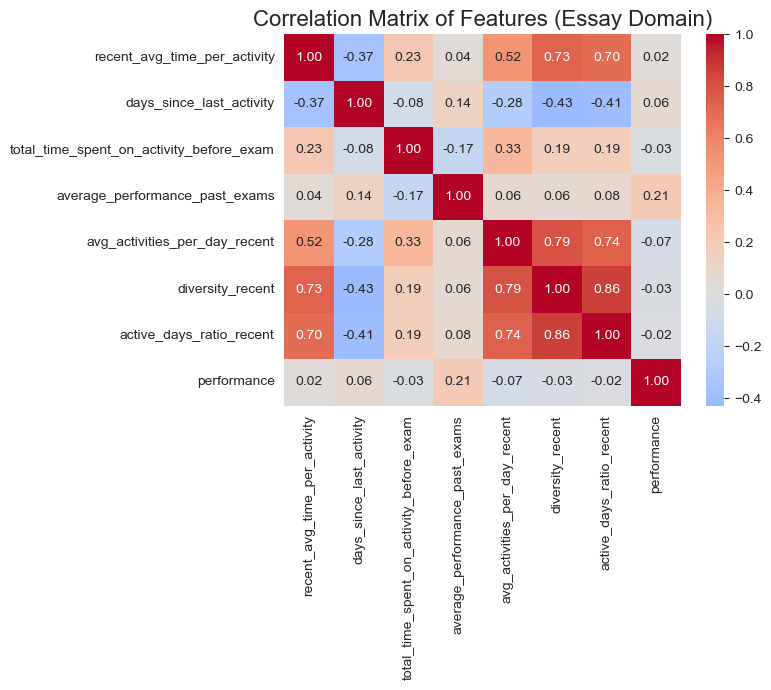

In [16]:
correlation_matrix_essay = final_df_essay[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_essay, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Essay Domain)", fontsize=16)
plt.tight_layout()
plt.show()

#### Text data 

In [17]:
performances_text = performances[performances['domain']== 'text'].copy()
activity_text= activity[activity['domain']== 'text'].copy()

# Convert the date columns to datetime
activity_text['activity_updated'] = pd.to_datetime(activity_text['activity_updated'])
performances_text['time'] = pd.to_datetime(performances_text['time'])

# Loop over each exam (grouped by user) in performances_text and compute all features.
features_list = []

for user_id, user_exams in performances_text.groupby('user_id'):
    # Get corresponding activities for the user from activity_text and sort by date
    user_activities = activity_text[activity_text['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_text_features = performances_text.join(features_df, how='left')


# Scale the columns
scaled_values = scaler.fit_transform(performances_text_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_text_features.index)
remaining_df = performances_text_features.drop(columns=columns_to_scale)
final_df_text = pd.concat([scaled_df, remaining_df], axis=1)

In [18]:
final_df_text.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    307
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              122
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [19]:
print('Total Nb of rows :', final_df_text.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum()/ final_df_text.user_id.count() * 100)

Total Nb of rows : 445
Nb of rows where we are missing feature values : 356
Percentage of rows where we are missing feature values : 80.0


**Comment:** The text domain has even less data available, with only 445 rows usable for training. 

**Comment:** Approximately 80% of the rows are missing with most coming from "days_since_last_activity". This means that users took the exam with no prior activity logs, meaning that, for our research question, these rows are useless since we are trying to predict performance based on past activity. There are also many rows where the "average_performance_past_exams" feature is missing, which will prove problematic.

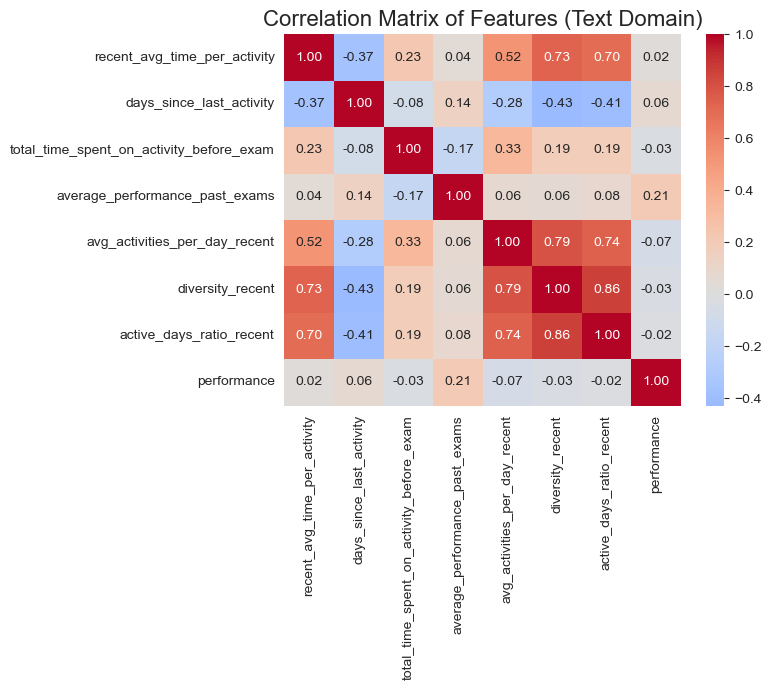

In [20]:
correlation_matrix_text = final_df_essay[feature_columns].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix_text, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features (Text Domain)", fontsize=16)
plt.tight_layout()
plt.show()

**Discussion of Processing Analysis**


When looking at the correlation analysis, we observe that the feature most strongly correlated with performance is "average_performance_past_exams." This presents a significant problem for the essay and text datasets, where not only are there very few rows to begin with, but this important feature is often missing. As a result, we decided to focus our efforts on the math data, where we have a much healthier number of data points available.

We did attempt to train models on the essay and text data; however, the performance was very poor, likely due to the limited amount of training examples and the missing key features. Training a model with so little data is highly unreliable and unlikely to generalize well. On the other hand, if our approach works well on the math data, it suggests that the methodology could be transferable to other domains, provided enough data points are available to fit a model properly.

## Task 2: Model Building

**Comment:** Seeing the lack of data available to us for both the text and essay domains, we decided to concentrate on the math data for the following parts. We also tried out multiple models to see if we could improve performance at all. Therefore, all following models are solely for the math data.

### Method 0 : Simple Linear Regression where we drop NAN

Sometimes, the simplest approaches can be the most effective. For our baseline model, we began by dropping any rows containing missing values (NaNs) to ensure a clean dataset. We then applied a simple linear regression model to predict exam performance based on the available features. This served as a straightforward benchmark to compare against more complex models.

In [21]:
final_df_math_drop = final_df_math.copy()
final_df_math_drop.dropna(inplace=True)


# Linear Regression Model
mod_method0 = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_math_drop)
# Fit the model
res_method0 = mod_method0.fit()

# Print regression results summary 
#print(res_method0.summary())

### Method 1 : Mixed Effects Linear Regression where we drop NAN and cluster the users 

To enhance our simple linear regression model, we employed a K-Means clustering approach to group users based on their feature profiles. This allowed us to account for heterogeneity among users by capturing patterns in behavior and performance. By incorporating these clusters as mixed effects, we aimed to improve the model’s ability to generalize across diverse user groups and better explain variations in exam outcomes.

In [22]:
# Collapse to one row per user for clustering
user_feats = final_df_math_drop.groupby('user_id')[['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam', 'average_performance_past_exams', 'avg_activities_per_day_recent', 'active_days_ratio_recent', 'diversity_recent']].mean().reset_index()

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=0)
user_feats['cluster'] = kmeans.fit_predict(user_feats.drop(columns='user_id'))

# Merge cluster label back into final_df
df2 = final_df_math_drop.merge(user_feats[['user_id','cluster']], on='user_id')

# Fit a mixed‐effects model with random intercept per cluster
mod_method1 = smf.mixedlm("performance ~ recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent",df2,groups="cluster")
res_method1 = mod_method1.fit(reml=False)

# In-sample predictions
df2["pred_cluster"] = res_method1.predict(df2)

### Method 2 : Simple Linear Regression where we impute the missing NAN values with the median value for that exam


For this method we used a simple linear regression model with median imputation for missing values. Specifically, any NaN values were filled with the median value for the corresponding feature within each exam. This approach preserved more data compared to dropping rows and allowed the model to leverage a broader training set while maintaining simplicity.

In [23]:
performance_math_median = performances_math_features.copy()

# Fill by test_id median
performance_math_median['average_performance_past_exams'] = (
    performance_math_median
    .groupby('test_id')['average_performance_past_exams']
    .transform(lambda x: x.fillna(x.median()))
    .fillna(performance_math_median['average_performance_past_exams'].median())   # fallback to global median if a test has no median
)

performance_math_median['days_since_last_activity'] = (
    performance_math_median
    .groupby('test_id')['days_since_last_activity']
    .transform(lambda x: x.fillna(x.median()))
    .fillna(performance_math_median['days_since_last_activity'].median())   # fallback to global median if a test has no median
)

#performance_math_median.dropna(inplace=True) 

# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_median[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_median.index)
remaining_df = performance_math_median.drop(columns=columns_to_scale)
final_df_med = pd.concat([scaled_df, remaining_df], axis=1)

In [24]:
# Linear Regression Model
mod_method2 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_med)

# Fit the model
res_method2 = mod_method2.fit()

### Method 3 : Simple Linear Regression where we impute the missing NAN values using KNN

For Method 3, we applied a simple linear regression model with K-Nearest Neighbors (KNN) imputation for missing values. Instead of using global statistics like the median, KNN imputation estimates missing values based on the most similar observations in the dataset. This method allows for more context-aware imputations, potentially preserving underlying data relationships and improving the model’s predictive performance.

In [25]:
performance_math_impute = performances_math_features.copy()

sim_features = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam',
                'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

performance_math_impute['avg_perf_past_exams_imputed'] = performance_math_impute['average_performance_past_exams']
performance_math_impute['days_since_last_activity_imputed'] = performance_math_impute['days_since_last_activity']


for test_id, group in performance_math_impute.groupby('test_id'):
    group_idx = group.index
    

    feat_mat = group[sim_features].copy()
    feat_mat_filled = feat_mat.fillna(feat_mat.median())


    # Impute avg_perf_past_exams
    missing_perf_idx = group[group['average_performance_past_exams'].isna()].index
    candidates_perf = group[group['average_performance_past_exams'].notna()]

    if len(missing_perf_idx) > 0 and len(candidates_perf) > 0:
        X_train = feat_mat_filled.loc[candidates_perf.index].values
        X_query = feat_mat_filled.loc[missing_perf_idx].values
        k = min(3, X_train.shape[0])
        nbrs = NearestNeighbors(n_neighbors=k).fit(X_train)
        _, neighbors = nbrs.kneighbors(X_query)
        candidate_scores = candidates_perf['performance'].values

        for i, idx in enumerate(missing_perf_idx):
            nbr_idxs = neighbors[i]
            imputed_val = candidate_scores[nbr_idxs].mean()
            performance_math_impute.at[idx, 'avg_perf_past_exams_imputed'] = imputed_val


    # Impute days_since_last_activity
    missing_days_idx = group[group['days_since_last_activity'].isna()].index
    candidates_days = group[group['days_since_last_activity'].notna()]

    if len(missing_days_idx) > 0 and len(candidates_days) > 0:
        X_train = feat_mat_filled.loc[candidates_days.index].values
        X_query = feat_mat_filled.loc[missing_days_idx].values
        k = min(3, X_train.shape[0])
        nbrs = NearestNeighbors(n_neighbors=k).fit(X_train)
        _, neighbors = nbrs.kneighbors(X_query)
        candidate_days = candidates_days['days_since_last_activity'].values

        for i, idx in enumerate(missing_days_idx):
            nbr_idxs = neighbors[i]
            imputed_val = candidate_days[nbr_idxs].mean()
            performance_math_impute.at[idx, 'days_since_last_activity_imputed'] = imputed_val


performance_math_impute['average_performance_past_exams'] = performance_math_impute['avg_perf_past_exams_imputed']
performance_math_impute['days_since_last_activity'] = performance_math_impute['days_since_last_activity_imputed']
performance_math_impute.drop(columns=['avg_perf_past_exams_imputed', 'days_since_last_activity_imputed'], inplace=True)

In [26]:
# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']
scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_impute[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_impute.index)
remaining_df = performance_math_impute.drop(columns=columns_to_scale)
final_df_impute = pd.concat([scaled_df, remaining_df], axis=1)

In [27]:
###final_df_impute.dropna(inplace=True) # drop the remaining NaNs

# Linear Regression Model
mod_method3 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_impute)

# Fit the model
res_method3 = mod_method3.fit()

### Method 4 : Gradient Boosting Regressor that accepts NAN values

For Method 4, we used a Gradient Boosting Regressor that natively handles missing values. Unlike simpler models, gradient boosting can internally learn how to deal with NaNs during training by simply sending them “one way or the other” at each split, making it well-suited for real-world, imperfect data. This approach allowed us to retain the full dataset without requiring explicit imputation, while benefiting from the model's ability to capture complex, non-linear relationships in the features.



In [28]:
df_gb = performances_math_features.copy()

feature_cols = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam','average_performance_past_exams',
    'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

X = df_gb[feature_cols]
y = df_gb['performance']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: scale → gradient boost
pipeline = Pipeline([
    ('scaler',    StandardScaler()),
    ('hgb',    HistGradientBoostingRegressor(random_state=42))
])

# Grid search for key hyperparameters
param_grid = {'hgb__learning_rate': [0.05, 0.1], 'hgb__max_iter':      [100, 200], 'hgb__max_depth':     [3, 5], 'hgb__min_samples_leaf': [20, 50]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the model
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'hgb__learning_rate': 0.05, 'hgb__max_depth': 3, 'hgb__max_iter': 100, 'hgb__min_samples_leaf': 50}


## Task 3: Model Evaluation

### Model 0 :

Simple Linear Regression where we drop NAN

In [29]:
# Print regression results summary
print(res_method0.summary())


final_df_math_drop['predicted_performance'] = res_method0.fittedvalues
rmse_method0 = mean_squared_error(final_df_math_drop["performance"], final_df_math_drop['predicted_performance'])
print('RMSE :', rmse_method0)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     202.1
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.41e-220
Time:                        17:54:22   Log-Likelihood:                -15422.
No. Observations:                3340   AIC:                         3.086e+04
Df Residuals:                    3333   BIC:                         3.090e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**Comment:** The simple linear regression model where we drop the NAN's has an R-squared of 0.267, meaning it explains 26.7% of the variance in performance. While this is a relatively modest value, it's actually quite good for real world data, which tends to be noisy and influenced by factors not captured in the model. The significant predictors, such as "recent_average_time_per_activity" and "total_time_spent_on_activity_before_exam" suggest the model is capturing meaningful patterns. The "average_performance_in_past_exams" feature is also significant and has the largest coefficient. This reinforces our decision to focus on the math data, as this feature is less available in the essay and text domain data.

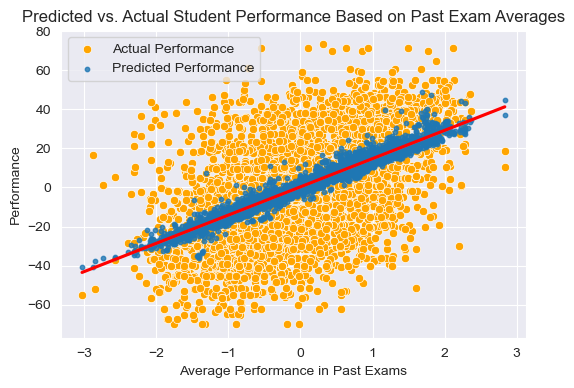

In [30]:
final_df_math_drop['predicted_performance'] = res_method0.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='average_performance_past_exams', y='performance', data=final_df_math_drop, color='orange', label='Actual Performance')
sns.regplot(x='average_performance_past_exams', y='predicted_performance', data=final_df_math_drop, scatter_kws={'s': 10}, line_kws={'color': 'red'}, label='Predicted Performance')

plt.xlabel('Average Performance in Past Exams')
plt.ylabel('Performance')
plt.title('Predicted vs. Actual Student Performance Based on Past Exam Averages')
plt.legend()
plt.show()

**Comment:** The plot illustrates the relationship between the "average_performance_in_past_exams" and the model’s predicted performance. This feature showed the strongest correlation with actual performance in the preliminary analysis and also emerged as the most significant predictor in our model, with the largest coefficient. Visualizing its impact helps us understand how well the model captures this relationship. As seen in the plot, there is a clear upward trend in the actual performance data, and the model has effectively captured this pattern in its predictions.

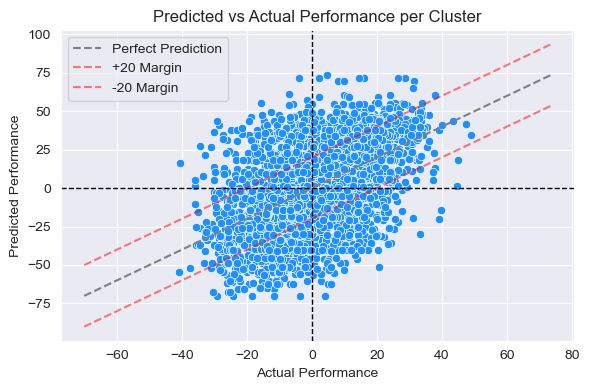

In [31]:
plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df_math_drop, color='dodgerblue')

min_val = min(final_df_math_drop['performance'].min(), final_df_math_drop['predicted_performance'].min())
max_val = max(final_df_math_drop['performance'].max(), final_df_math_drop['predicted_performance'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", label='Perfect Prediction')

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

plt.xlabel('Actual Performance')
plt.ylabel('Predicted Performance')
plt.title("Predicted vs Actual Performance per Cluster")
plt.legend()
plt.tight_layout()
plt.show()

**Comment:** By examining the model’s predictions against the actual performance values, we gain a better sense of its precision. The model captures the overall trend in performance reasonably well, though there is still a noticeable amount of error — which is to be expected given the complexity and variability of the data.

That said, there are encouraging signs. The black dashed lines divide the plot into four quadrants that reflect the directional accuracy of the model’s predictions. A well-performing model should have most points in the top-right (both predicted and actual are high) and bottom-left (both predicted and actual are low) quadrants. In this case, the majority of points do fall into these two quadrants, suggesting that the model generally gets the direction of performance correct, even if it doesn’t always predict the exact value.


In [32]:
conditions_model0 = [
    (final_df_math_drop["predicted_performance"] >= mean_pred) & (final_df_math_drop["performance"] >= mean_actual),  # TP
    (final_df_math_drop["predicted_performance"] < mean_pred) & (final_df_math_drop["performance"] < mean_actual),    # TN
    (final_df_math_drop["predicted_performance"] >= mean_pred) & (final_df_math_drop["performance"] < mean_actual),   # FP
    (final_df_math_drop["predicted_performance"] < mean_pred) & (final_df_math_drop["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df_math_drop['quadrant'] = np.select(conditions_model0, choices, default='Other')

counts_model0 = final_df_math_drop['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_model0)

tp = counts_model0.get('TP', 0)
tn = counts_model0.get('TN', 0)
fp = counts_model0.get('FP', 0)
fn = counts_model0.get('FN', 0)

directional_accuracy_model0 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model0:.4f}")

Quadrant Classification Counts:
quadrant
TP    1178
TN    1170
FN     523
FP     469
Name: count, dtype: int64

Directional Accuracy: 0.7030


**Comment:** The directional accuracy of our model is 0.7030, meaning it correctly predicts whether a student’s performance will be above or below zero in 70% of cases. This indicates that the model is successfully learning meaningful patterns in user behavior that help it distinguish between generally good and poor performance. While it’s not perfect, this level of directional accuracy is an encouraging sign!

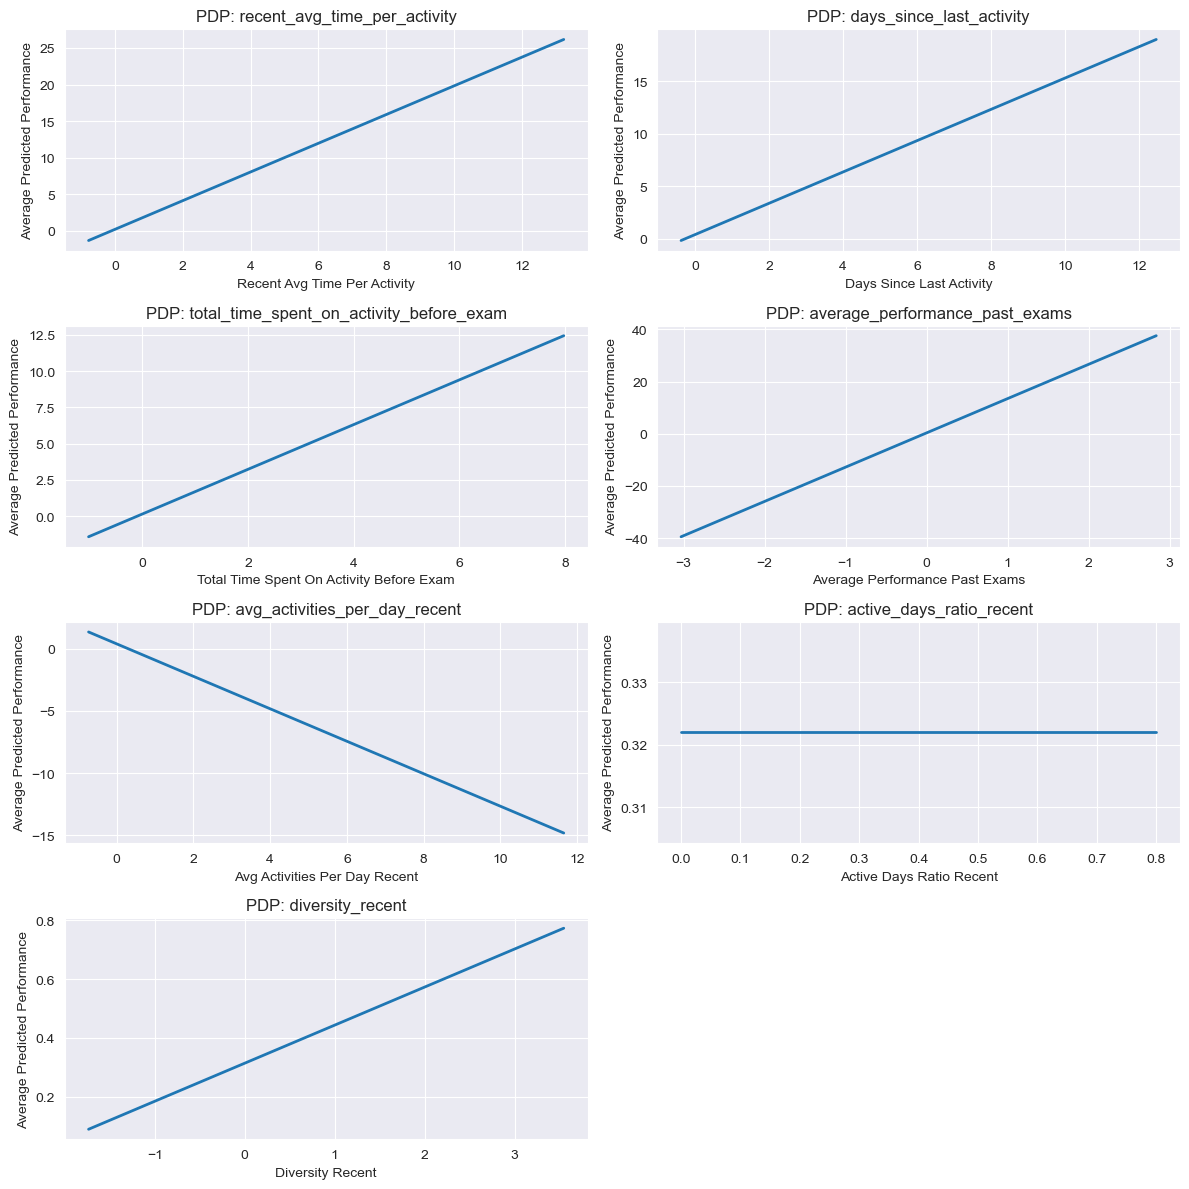

In [44]:


# --- assume you have:
# res = your fitted smf.ols(...).fit()
# X_train = DataFrame of your feature columns used in that formula

def manual_pdp(res, X, feature, grid_points=1000):
    """
    Compute a 1-D partial dependence for `feature`:
    - X: DataFrame of training inputs
    - res: fitted statsmodels results (.predict accepts X)
    - feature: string name of the column
    - grid_points: # points in the feature's value grid
    Returns (values, pdp)
    """
    vals = np.linspace(X[feature].min(), X[feature].max(), grid_points)
    pdp   = []

    # For each value v, fix X[feature]=v and average the prediction
    for v in vals:
        Xv = X.copy()
        Xv[feature] = v
        preds = res.predict(Xv)     # uses the same formula columns
        pdp.append(preds.mean())

    return vals, np.array(pdp)

# List of features
features = [
    'recent_avg_time_per_activity',
    'days_since_last_activity',
    'total_time_spent_on_activity_before_exam',
    'average_performance_past_exams',
    'avg_activities_per_day_recent',
    'active_days_ratio_recent',
    'diversity_recent'
]

# Plot PDP for each feature
grid_points = 100
num_feats = len(features)
ncols = 2
nrows = int(np.ceil(num_feats / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3))
axes = axes.flatten()

for i, feat in enumerate(features):
    vals, pdp_vals = manual_pdp(res_method0, final_df_math_drop, feat, grid_points)
    ax = axes[i]
    ax.plot(vals, pdp_vals, linewidth=2)
    ax.set_title(f"PDP: {feat}")
    ax.set_xlabel(feat.replace('_', ' ').title())
    ax.set_ylabel("Average Predicted Performance")
    ax.grid(True)

# Remove any extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

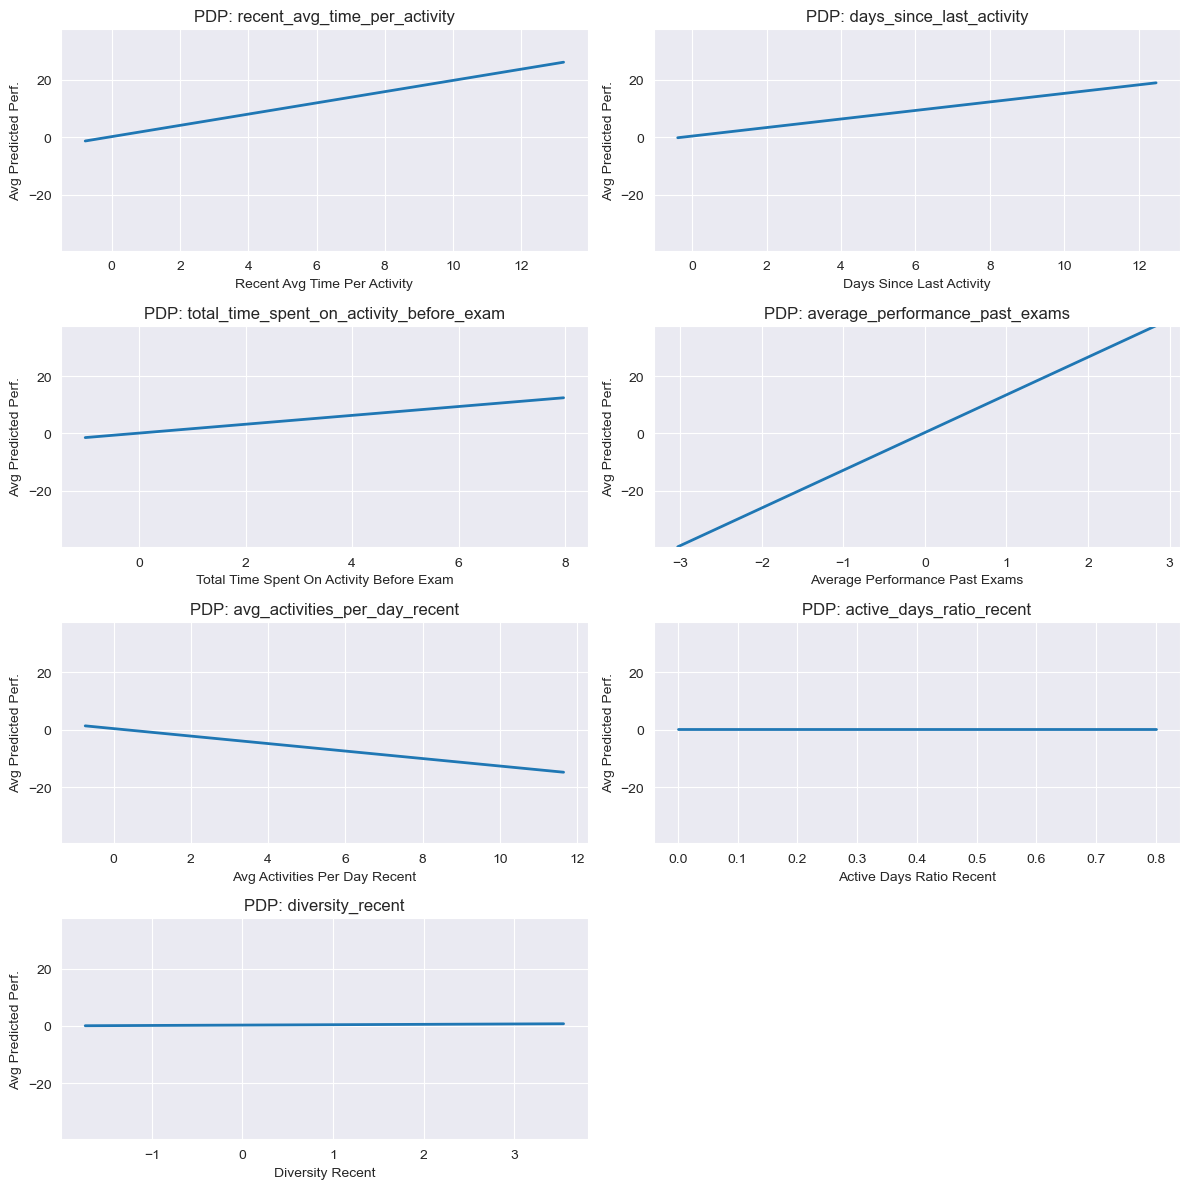

In [45]:
# 1) Compute all PDPs and record global y‐range
all_curves = {}
global_min, global_max = np.inf, -np.inf

scaler = StandardScaler()

for feat in features:
    vals, pdp_vals = manual_pdp(res_method0, final_df_math_drop, feat, grid_points=100)
    all_curves[feat] = (vals, pdp_vals)
    global_min = min(global_min, pdp_vals.min())
    global_max = max(global_max, pdp_vals.max())

# 2) Plot them on a unified y‐scale
n = len(features)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3))
axes = axes.flatten()

for i, feat in enumerate(features):
    vals, pdp_vals = all_curves[feat]
    ax = axes[i]
    ax.plot(vals, pdp_vals, linewidth=2)
    ax.set_title(f"PDP: {feat}")
    ax.set_xlabel(feat.replace('_',' ').title())
    ax.set_ylabel("Avg Predicted Perf.")
    ax.set_ylim(global_min, global_max)   # same y‐scale everywhere
    ax.grid(True)

# remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Model 1 :

Mixed Effects Linear Regression where we drop NAN and cluster the users

In [33]:
print(res_method1.summary())

# Compute R² and RMSE
r2_cluster = r2_score(df2["performance"], df2["pred_cluster"])
rmse_cluster = mean_squared_error(df2["performance"], df2["pred_cluster"])

print("Cluster‐model  AIC:",  res_method1.aic, "  BIC:", res_method1.bic)
print(f"Cluster‐model  R² = {r2_cluster:.3f},  RMSE = {rmse_cluster:.3f}")

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         performance
No. Observations:           3340            Method:                     ML         
No. Groups:                 3               Scale:                      590.3304   
Min. group size:            27              Log-Likelihood:             -15399.2191
Max. group size:            1902            Converged:                  Yes        
Mean group size:            1113.3                                                 
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.242    2.875  0.084 0.933 -5.394  5.878
recent_avg_time_per_activity              1.433    0.451  3.179 0.001  0.550  2.317
days_since_last

**Comment:** The mixed effects linear regression model has a R-squared value of 0.252. This is surprisingly lower than the simpler model 0, but not by much and it still seems to perform fairly well. The RMSE is also higher than model_0 which is another indicator of a worse fit to the data. For the significant features, "average_performance_past_exams" again seems to be the most prevelant feature, with other like "avg_activities_per_day_recent" and "recent_avg_time_per_activity" also contributing postiviely.

The clustering approach adds structure, but doesn’t yield a significant performance boost in this case.

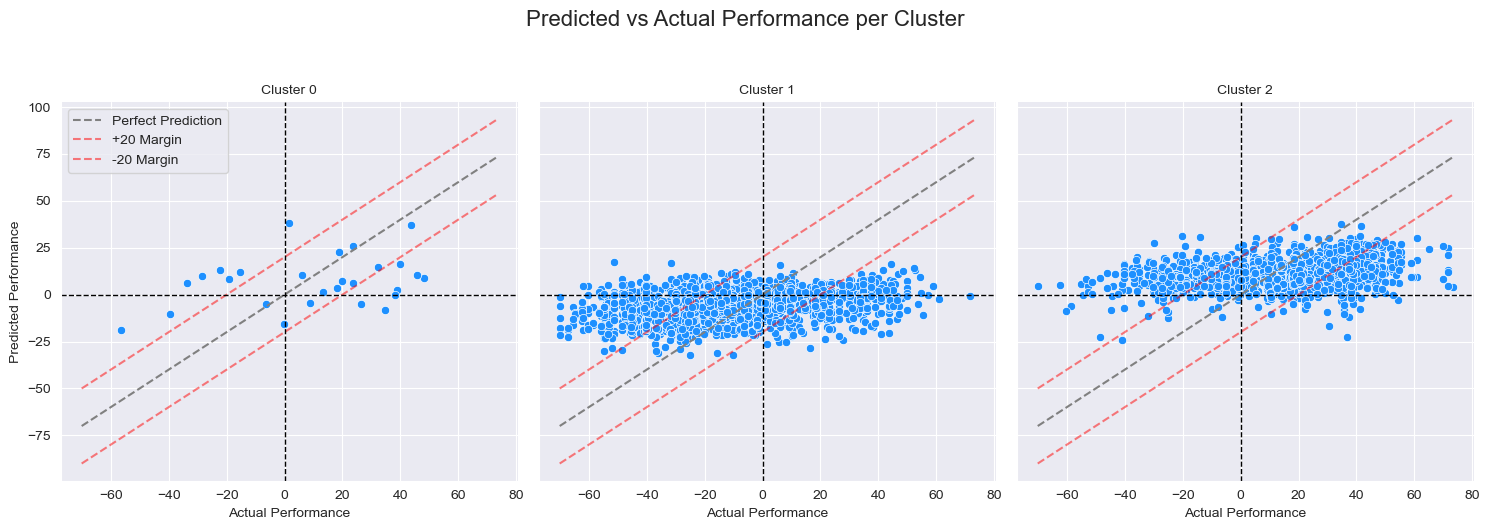

In [34]:
buffer = 20

g = sns.FacetGrid(df2, col="cluster", col_wrap=3, height=5, sharex=True, sharey=True)

g.map_dataframe(sns.scatterplot, x="performance", y="pred_cluster", color='dodgerblue')

min_val = min(df2["performance"].min(), df2["pred_cluster"].min())
max_val = max(df2["performance"].max(), df2["pred_cluster"].max())

for i, ax in enumerate(g.axes.flatten()):

    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray",
            label="Perfect Prediction" if i == 0 else "")

    ax.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5,
            label=f'+{buffer} Margin' if i == 0 else "")
    ax.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5,
            label=f'-{buffer} Margin' if i == 0 else "")

    mean_actual = 0
    mean_pred = 0

    ax.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
    ax.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

g.axes[0].legend()

g.set_axis_labels("Actual Performance", "Predicted Performance")
g.set_titles("Cluster {col_name}")
g.fig.suptitle("Predicted vs Actual Performance per Cluster", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [35]:
conditions_model1 = [
    (df2["pred_cluster"] >= mean_pred) & (df2["performance"] >= mean_actual),  # TP
    (df2["pred_cluster"] < mean_pred) & (df2["performance"] < mean_actual),    # TN
    (df2["pred_cluster"] >= mean_pred) & (df2["performance"] < mean_actual),   # FP
    (df2["pred_cluster"] < mean_pred) & (df2["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
df2['quadrant'] = np.select(conditions_model1, choices, default='Other')

counts_model1 =df2['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_model1)

tp = counts_model1.get('TP', 0)
tn = counts_model1.get('TN', 0)
fp = counts_model1.get('FP', 0)
fn = counts_model1.get('FN', 0)

directional_accuracy_model1 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model1:.4f}")

Quadrant Classification Counts:
quadrant
TP    1241
TN    1091
FP     548
FN     460
Name: count, dtype: int64

Directional Accuracy: 0.6982


**Comment:** When examining the predicted vs. actual performance plots by cluster, we can see that the clustering appears to have been effective in grouping students with similar characteristics. Clusters 1 and 2 contain the majority of students, with Cluster 1 tending to include those with lower performance levels, while Cluster 2 generally includes higher-performing students.

Although the model does not perfectly capture the variation in performance within each cluster, evident from the spread around the perfect prediction line, it still demonstrates meaningful signal. In particular, the directional accuracy remains around 70%, indicating that the model is reliably predicting whether a student will perform above or below the average. This is again a promising sign that the model is capturing relevant behavioral patterns, even if the exact predictions aren’t always precise. However, it is slightly lower than our simpler model.

### Model 2 :

Simple Linear Regression where we impute the missing NAN values with the median value for that exam

In [36]:
print(res_method2.summary())

final_df_med['predicted_performance'] = res_method2.fittedvalues
rmse_method2 = mean_squared_error(final_df_med["performance"], final_df_med['predicted_performance'])
print('RMSE :', rmse_method2)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     170.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          7.50e-220
Time:                        17:03:56   Log-Likelihood:                -17610.
No. Observations:                3810   AIC:                         3.524e+04
Df Residuals:                    3802   BIC:                         3.529e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**Comment:** The simple linear regression model with imputed NAN's has a R-squared value of 0.239. This is notably lower than both of the previous models. Among the significant predictors, "average_performance_past_exams" remains the most influential, followed by "recent_avg_time_per_activity" and "total_time_spent_on_activity_before_exam", all of which contribute positively to the model's predictive capability.

While performance declines slightly, the model still captures important relationships in the data.

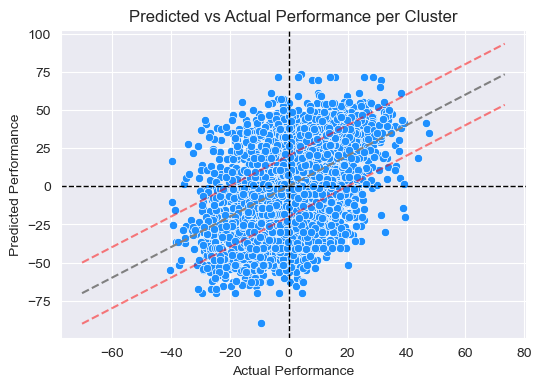

In [37]:
final_df_med['predicted_performance'] = res_method2.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df_med, color='dodgerblue')

min_val = min(final_df_math_drop['performance'].min(), final_df_math_drop['predicted_performance'].min())
max_val = max(final_df_math_drop['performance'].max(), final_df_math_drop['predicted_performance'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

plt.xlabel('Actual Performance')
plt.ylabel('Predicted Performance')
plt.title("Predicted vs Actual Performance per Cluster")

plt.show()

In [38]:
conditions_model2 = [
    (final_df_med["predicted_performance"] >= mean_pred) & (final_df_med["performance"] >= mean_actual),  # TP
    (final_df_med["predicted_performance"] < mean_pred) & (final_df_med["performance"] < mean_actual),    # TN
    (final_df_med["predicted_performance"] >= mean_pred) & (final_df_med["performance"] < mean_actual),   # FP
    (final_df_med["predicted_performance"] < mean_pred) & (final_df_med["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df_med['quadrant'] = np.select(conditions_model2, choices, default='Other')


counts_model2 = final_df_med['quadrant'].value_counts()
print("Quadrant Classification Counts:")
print(counts_model2)


tp = counts_model2.get('TP', 0)
tn = counts_model2.get('TN', 0)
fp = counts_model2.get('FP', 0)
fn = counts_model2.get('FN', 0)

directional_accuracy_model2 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_model2:.4f}")

Quadrant Classification Counts:
quadrant
TN    1323
TP    1249
FN     703
FP     535
Name: count, dtype: int64

Directional Accuracy: 0.6751


**Comment:** When examining the actual vs. predicted performance plot, we observe a similar overall trend as seen with the other models. Although the prediction errors remain relatively large, the model does capture the general direction of performance. This is further supported by the directional accuracy, which stands at 0.6751 which is slightly lower value compared to other models, but still indicative of acceptable performance in identifying upward or downward trends.

### Model 3 :

Simple Linear Regression where we impute the missing NAN values using KNN

In [39]:
print(res_method3.summary())

final_df_impute['predicted_performance'] = res_method3.fittedvalues
rmse_method3 = mean_squared_error(final_df_impute["performance"], final_df_impute['predicted_performance'])
print('RMSE :', rmse_method3)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     161.9
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          4.83e-210
Time:                        17:03:56   Log-Likelihood:                -17633.
No. Observations:                3810   AIC:                         3.528e+04
Df Residuals:                    3802   BIC:                         3.533e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

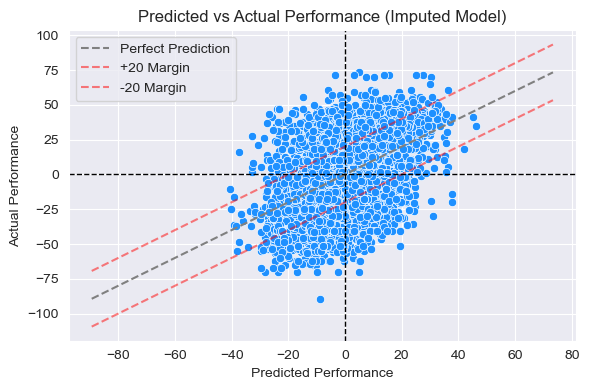

In [40]:
final_df_impute['predicted_performance'] = res_method3.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df_impute, color='dodgerblue')

min_val = min(final_df_impute['performance'].min(), final_df_impute['predicted_performance'].min())
max_val = max(final_df_impute['performance'].max(), final_df_impute['predicted_performance'].max())

plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", label='Perfect Prediction')

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)
plt.xlabel('Predicted Performance')
plt.ylabel('Actual Performance')
plt.title("Predicted vs Actual Performance (Imputed Model)")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
final_df_impute["predicted_performance"] = res_method3.fittedvalues

mean_actual = final_df_impute["performance"].mean()
mean_pred = final_df_impute["predicted_performance"].mean()

conditions_method3 = [
    (final_df_impute["predicted_performance"] >= mean_pred) & (final_df_impute["performance"] >= mean_actual),  # TP
    (final_df_impute["predicted_performance"] < mean_pred) & (final_df_impute["performance"] < mean_actual),    # TN
    (final_df_impute["predicted_performance"] >= mean_pred) & (final_df_impute["performance"] < mean_actual),   # FP
    (final_df_impute["predicted_performance"] < mean_pred) & (final_df_impute["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df_impute['quadrant'] = np.select(conditions_method3, choices, default='Other')

counts_method3 = final_df_impute['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_method3)

tp = counts_method3.get('TP', 0)
tn = counts_method3.get('TN', 0)
fp = counts_method3.get('FP', 0)
fn = counts_method3.get('FN', 0)

directional_accuracy_method3 = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_method3:.4f}")

Quadrant Classification Counts:
quadrant
TN    1289
TP    1280
FN     672
FP     569
Name: count, dtype: int64

Directional Accuracy: 0.6743


**Comment:** The simple linear regression model where missing values are imputed using KNN yields an R-squared of 0.230, which is lower than the baseline model where missing values are dropped (R² = 0.267) and slightly below the median-imputed version (R² = 0.239). While “average_performance_past_exams” remains the most influential predictor, the overall explanatory power of the model is modest. The RMSE is relatively high at 612.97, suggesting substantial error in the magnitude of predictions. However, the directional accuracy is 0.6743 which is comparable to other models, indicating that while the model struggles with precise estimates, it still captures whether performance will be above or below the mean with reasonable consistency.

This suggests that KNN imputation does not offer a clear improvement over simpler imputation strategies for this task.


### Model 4 :

Gradient Boosting Regressor that accepts NAN values

In [42]:
### Let see results for the orginal test data :

print("Test R²:", r2_score(y_test, y_pred))
r_squared_method4 = r2_score(y_test, y_pred)
print("Test RMSE:", mean_squared_error(y_test, y_pred))
rmse_method4 = mean_squared_error(y_test, y_pred)

Test R²: 0.2690266257416666
Test RMSE: 575.9933590519967


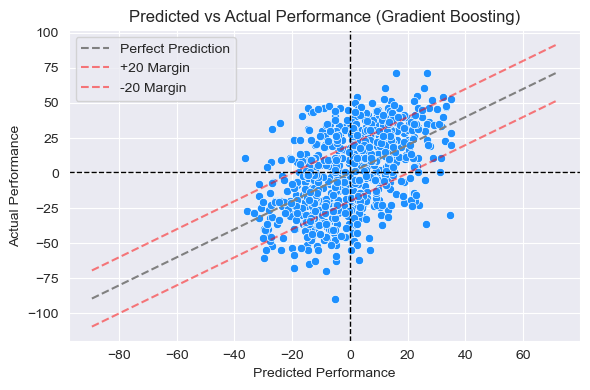

In [43]:
X_test['predicted_performance'] = best_model.predict(X_test)
X_test['performance'] = y_test

df_gb = X_test.copy()

plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=df_gb, color='dodgerblue')

min_val = min(df_gb['performance'].min(), df_gb['predicted_performance'].min())
max_val = max(df_gb['performance'].max(), df_gb['predicted_performance'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", label='Perfect Prediction')

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

# Use actual means or standardized zero if scaled
mean_actual = df_gb['performance'].mean()
mean_pred = df_gb['predicted_performance'].mean()
plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)

plt.xlabel('Predicted Performance')
plt.ylabel('Actual Performance')
plt.title("Predicted vs Actual Performance (Gradient Boosting)")
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
conditions_gb = [
    (df_gb["predicted_performance"] >= mean_pred) & (df_gb["performance"] >= mean_actual),  # TP
    (df_gb["predicted_performance"] < mean_pred) & (df_gb["performance"] < mean_actual),    # TN
    (df_gb["predicted_performance"] >= mean_pred) & (df_gb["performance"] < mean_actual),   # FP
    (df_gb["predicted_performance"] < mean_pred) & (df_gb["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
df_gb['quadrant'] = np.select(conditions_gb, choices, default='Other')

counts_gb = df_gb['quadrant'].value_counts()
print("Quadrant Classification Counts:")
print(counts_gb)

tp = counts_gb.get('TP', 0)
tn = counts_gb.get('TN', 0)
fp = counts_gb.get('FP', 0)
fn = counts_gb.get('FN', 0)

directional_accuracy_gb = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy (Gradient Boosting): {directional_accuracy_gb:.4f}")

Quadrant Classification Counts:
quadrant
TP    273
TN    257
FP    116
FN    116
Name: count, dtype: int64

Directional Accuracy (Gradient Boosting): 0.6955


In [45]:
### Let's do some cross validation and obtain results :

cv_scores_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)
cv_scores_rmse = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
print("5‑fold CV R²: %0.3f ± %0.3f" % (cv_scores_r2.mean(), cv_scores_r2.std()))
print("5‑fold CV RMSE: %0.3f ± %0.3f" % (-cv_scores_rmse.mean(), cv_scores_rmse.std()))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    model = best_model
    model.fit(X.iloc[train_idx], y.iloc[train_idx])

    y_pred = model.predict(X.iloc[test_idx])
    y_true = y.iloc[test_idx]

    mean_pred = y_pred.mean()
    mean_actual = y_true.mean()


    conditions = [
        (y_pred >= mean_pred) & (y_true >= mean_actual),  # TP
        (y_pred <  mean_pred) & (y_true <  mean_actual),  # TN
        (y_pred >= mean_pred) & (y_true <  mean_actual),  # FP
        (y_pred <  mean_pred) & (y_true >= mean_actual),  # FN
    ]
    choices = ['TP', 'TN', 'FP', 'FN']
    quadrant = np.select(conditions, choices, default='Other')

    counts = pd.Series(quadrant).value_counts()
    tp = counts.get('TP', 0)
    tn = counts.get('TN', 0)
    fp = counts.get('FP', 0)
    fn = counts.get('FN', 0)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fold_accuracies.append(accuracy)


#print("Directional Accuracy per fold:", [f"{acc:.4f}" for acc in fold_accuracies])
print("Mean Directional Accuracy: %.4f ± %.4f" % (np.mean(fold_accuracies), np.std(fold_accuracies)))

5‑fold CV R²: 0.223 ± 0.080
5‑fold CV RMSE: 600.792 ± 37.358
Mean Directional Accuracy: 0.6709 ± 0.0238


**Comment:** When evaluating the results on the originally defined test set, the model appears to outperform all previously tested alternatives, it achieves a high R-squared, strong directional accuracy, and the lowest RMSE observed so far. However, once cross-validation is applied, providing multiple train-test splits, a more realistic picture of model performance emerges. The cross-validated metrics reveal that the model’s performance is less consistent and not as strong as initially suggested. This discrepancy indicates that the model may have overfit the original test set or benefitted from favourable data conditions. Cross-validation offers a more robust estimate of generalization, and in this case, it highlights that the model may not be reliably superior on unseen data.

### Comparisons between the models

To compare the various models, we have used a plot to visualise the main metrics for each approach: RMSE, R-squared, and Directional Accuracy

Since these metrics are on different scales (RMSE can be in the hundreds while R-squared and Directional Accuracy range between 0 and 1), we normalized them to allow for a fair visual comparison. This also helps highlight the relative strengths and weaknesses of each model across the evaluation criteria seeing that R-squared and Accuracy are similar :

- RMSE reflects how far off predictions are on average (lower is better).

- R-squared indicates how much variance in the data the model explains (higher is better).

- Directional Accuracy evaluates how well the model predicts the direction of performance (above or below the mean), serving as a robustness check.

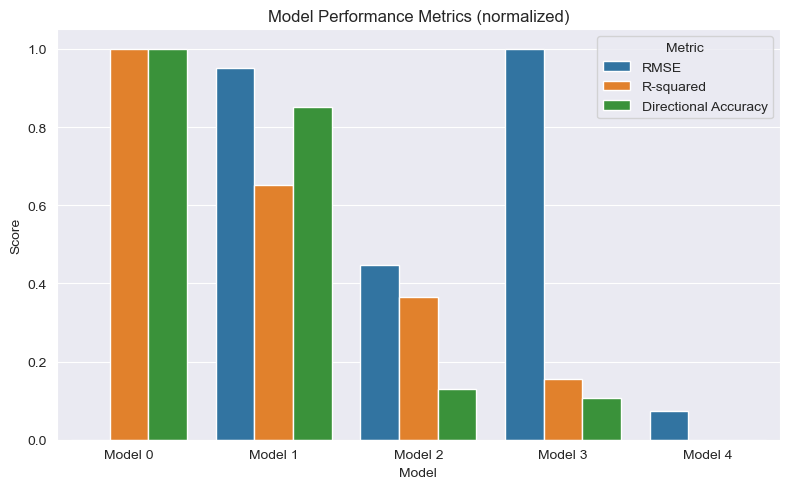

In [46]:
# Data
models = ['Model 0', 'Model 1', 'Model 2', 'Model 3', 'Model 4']
rmse_values = [rmse_method0, rmse_cluster, rmse_method2, rmse_method3, -cv_scores_rmse.mean()]
r2_values = [res_method0.rsquared, r2_cluster, res_method2.rsquared, res_method3.rsquared, cv_scores_r2.mean()]
directional_accuracy_values = [directional_accuracy_model0, directional_accuracy_model1, directional_accuracy_model2, directional_accuracy_method3, np.mean(fold_accuracies)]

rmse_values = [round(val, 4) for val in rmse_values]
r2_values = [round(val, 4) for val in r2_values]
directional_accuracy_values = [round(val, 4) for val in directional_accuracy_values]


metrics_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Directional Accuracy': directional_accuracy_values
})



scaler = MinMaxScaler()
metrics_scaled = pd.DataFrame(
    scaler.fit_transform(metrics_df.drop(columns='Model')),
    columns=['RMSE', 'R-squared', 'Directional Accuracy']
)

metrics_scaled['Model'] = models



metrics_melted = metrics_scaled.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted)
plt.title('Model Performance Metrics (normalized)')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

**Discussion of the model's behaviour**

Across all evaluated models the simplest linear regression dropping rows with missing values consistently demonstrates the best overall performance. This can be seen in the above plot where we can clearly notice that it achieves the highest R-squared, lowest RMSE, and strongest directional accuracy. This indicates that it not only predicts values more accurately but also more reliably captures whether performance is good or bad, which means that the model has learned meaningful patterns in the data. Despite its simplicity, Model 0 benefits from having access to complete and informative features, especially “average_performance_past_exam”, which proves to be the most influential predictor across all models.

In contrast, models that attempt to impute missing values, whether using the median or KNN imputation do not show clear improvements. In fact, these methods tend to slightly reduce performance, likely because imputing this critical feature introduces noise or masks meaningful patterns. This suggests that when such an important predictor is missing, the corresponding cases are inherently more difficult to model, and no imputation method fully compensates for the lack of reliable input data...

The mixed effects model adds some interpretability by accounting for within-group variance via clustering, and while it performs reasonably well in terms of directional accuracy (second best model), it does not surpass the baseline model.

Finally, Model 4, which initially appeared to outperform all others on the original test set, was later revealed through cross-validation to have more modest and inconsistent performance. This highlights the importance of using robust evaluation methods: a model that seems optimal under one data split may not generalize well to other unseen samples, emphasizing the risk of overfitting or relying on favorable test conditions.

In summary, simplicity, when combined with complete and reliable feature data, outperforms more complex approaches in this case. The critical takeaway is that data completeness and feature availability, particularly for key predictors, have a greater impact on performance than model complexity or imputation strategy.



## Conclusion

**Research Question: Can we predict users’ performance based on their activity behaviour?**

**Answer:**
Yes, to a meaningful extent. Our results show that activity behaviour, particularly metrics like average performance in past exams, time spent on activities, and recent engagement patterns, can be used to predict performance. The simplest linear model, using clean data and without complex imputation or clustering, consistently performed best across key metrics such as R-squared, RMSE, and directional accuracy. This suggests that core behavioural features are strong indicators of user performance.

However, performance prediction is far from perfect. While the models generally captured the direction of performance (above or below average) with around 67–70% accuracy, the exact scores often showed high variance. This implies that while we can confidently distinguish between likely high and low performing users, predicting precise performance is still challenging, likely due to unobserved factors not captured in activity data alone.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*

- **Franziska** worked on the data cleaning, preprocessing, cleaning up the main notebook and milestone 5
- **Fletcher** worked on the data cleaning, creating the main notebook, model evaluation and the report
- **Oscar** worked on the feature extraction, the model creation, model evaluation and the report

Overall, the team worked well together. Everyone contributed and took responsibility for different tasks. Overall, we are happy with this milestone :)

For the next milestone, we could improve by starting the report a bit earlier and having more regular check-ins to stay on the same page. This would help spread the workload more evenly, avoid doing the same tasks multiple times and avoid rushing at the end.

## Annexe



For this model, we simply dropped the two features that required a valid activity_completed timestamp (recent_avg_time_per_activity and total_time_spent_on_activity_before_exam). This lets us try to fit the model with the other 50% of the data that was missing from the other models.

In [47]:
activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

In [48]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Rolling window for recent activity
rolling_window_days = 10

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

def compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']

    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()

    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}

    # Recent average time per activity (rolling window)
    #total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    #features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0

    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan

    # Total time spent on activities before the exam
    #features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0

    # Average percentage on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan

    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan

    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)

In [49]:
# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
columns_to_scale = [ 'days_since_last_activity','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df = pd.concat([scaled_df, remaining_df], axis=1)

In [50]:
# Linear Regression Model
mod_annexe = smf.ols(
    formula='performance ~  days_since_last_activity + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent',
    data=final_df)

# Fit the model
res_annexe = mod_annexe.fit()

# Print regression results summary
print(res_annexe.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     233.1
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          5.80e-214
Time:                        17:04:01   Log-Likelihood:                -15444.
No. Observations:                3341   AIC:                         3.090e+04
Df Residuals:                    3335   BIC:                         3.094e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

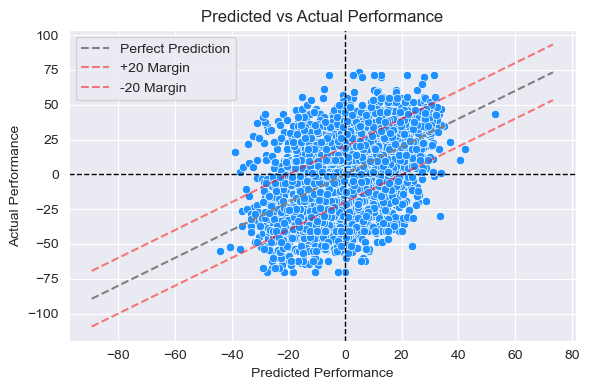

In [51]:
final_df['predicted_performance'] = res_annexe.fittedvalues

plt.figure(figsize=(6, 4))

sns.scatterplot(x='predicted_performance', y='performance', data=final_df, color='dodgerblue')

min_val = min(final_df['performance'].min(), final_df['predicted_performance'].min())
max_val = max(final_df['performance'].max(), final_df['predicted_performance'].max())

plt.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray", label='Perfect Prediction')

buffer = 20
plt.plot([min_val, max_val], [min_val + buffer, max_val + buffer], ls="--", color="red", alpha=0.5, label=f'+{buffer} Margin')
plt.plot([min_val, max_val], [min_val - buffer, max_val - buffer], ls="--", color="red", alpha=0.5, label=f'-{buffer} Margin')

mean_actual = 0
mean_pred = 0

plt.axhline(mean_actual, color="black", linestyle="--", linewidth=1)
plt.axvline(mean_pred, color="black", linestyle="--", linewidth=1)
plt.xlabel('Predicted Performance')
plt.ylabel('Actual Performance')
plt.title("Predicted vs Actual Performance")
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
conditions_annexe = [
    (final_df["predicted_performance"] >= mean_pred) & (final_df["performance"] >= mean_actual),  # TP
    (final_df["predicted_performance"] < mean_pred) & (final_df["performance"] < mean_actual),    # TN
    (final_df["predicted_performance"] >= mean_pred) & (final_df["performance"] < mean_actual),   # FP
    (final_df["predicted_performance"] < mean_pred) & (final_df["performance"] >= mean_actual),   # FN
]

choices = ['TP', 'TN', 'FP', 'FN']
final_df['quadrant'] = np.select(conditions_annexe, choices, default='Other')

counts_annexe = final_df['quadrant'].value_counts()

print("Quadrant Classification Counts:")
print(counts_annexe)

tp = counts_annexe.get('TP', 0)
tn = counts_annexe.get('TN', 0)
fp = counts_annexe.get('FP', 0)
fn = counts_annexe.get('FN', 0)

directional_accuracy_annexe = (tp + tn) / (tp + tn + fp + fn)
print(f"\nDirectional Accuracy: {directional_accuracy_annexe:.4f}")

Quadrant Classification Counts:
quadrant
TP       1196
TN       1148
FN        506
FP        491
Other     469
Name: count, dtype: int64

Directional Accuracy: 0.7016


**Comment:** The model yields an R² of 0.259 and a directional accuracy of 0.7016, compared to the baseline Model 0 (drop-NaN) with R² = 0.267 and directional accuracy = 0.7030. Because of those slightly better performances, we decided not to exclude the activity_completed-dependent features in the models we investigated. But the small drop in R² (~0.008) indicates that the precise “time-in-minutes” features just adds modest explanatory power, and that the remaining five features still capture most of the variance. Meanwhile, the nearly identical directional accuracy shows the model’s ability to predict whether a student will perform above or below their mean remains robust, even without the time-spent metrics. This suggests that while “recent_avg_time_per_activity” and “total_time_spent_on_activity_before_exam” improve point-estimate accuracy, a model built on the other five features can still deliver almost the same directional insight across the full dataset. Those non-activity_completed-dependent models could probably be investigated further for milestone 6.
